# Sanitization

In this notebook, we try some sanitization approaches.

In [8]:
%run notebook_utils.py

In [23]:
import pandas as pd
import re
import matplotlib
import random

# set big font in plots
SMALL_SIZE = 16
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

%matplotlib inline

In [10]:
X, y = load_data()
y_labels = [langs[i] for i in y]

# Statistics about the dataset

Begin by better understanding the dataset.

## Length of the samples

As shown below, one problem is that the average length of the sentences is quite different between Swiss German and non Swiss German sentences. As a result, using tf normalisation in the vectorizer will be important.

In [11]:
# create a dataframe
df = pd.DataFrame({'x': X, 'y': y, 'y_label': y_labels})
# add a column with the length of each sentence
df['x_len'] = df['x'].apply(len)

In [12]:
print("Statistics about the size of the data:\n")
df['x_len'].describe()

Statistics about the size of the data:



count    36939.000000
mean       117.385934
std         58.424855
min          0.000000
25%         73.000000
50%        110.000000
75%        156.000000
max        805.000000
Name: x_len, dtype: float64

In [13]:
print("Statistics about the size of the data, grouped by label:")
df.groupby('y_label')['x_len'].describe()

Statistics about the size of the data, grouped by label:


,count,mean,std,min,25%,50%,75%,max
y_label,,,,,,,,
de,7388.0,121.413238,52.378233,0.0,80.00,113.0,157.0,255.0
en,7388.0,128.125880,53.234784,0.0,87.75,122.0,165.0,255.0
fr,7388.0,121.761640,53.323961,0.0,80.00,115.0,157.0,255.0
it,7388.0,132.319978,54.441031,0.0,90.00,126.0,171.0,255.0
sg,7387.0,83.304318,64.414510,0.0,37.00,66.0,113.0,805.0


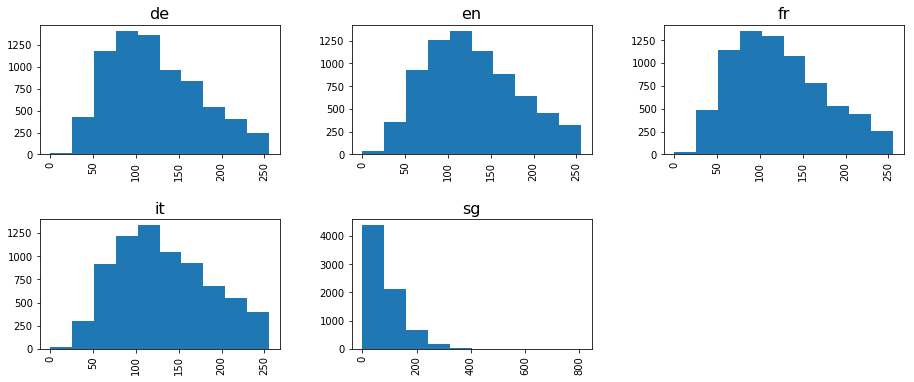

In [24]:
_ = df['x_len'].hist(by=df['y_label'], figsize=(15,6), layout=(2,3))

## Sanitization 1: remove all non-letter

In [8]:
reg_nonletters = re.compile("[^\w ]|\d|_")

def remove_nonletters(text: str) -> str: return re.sub(reg_nonletters, " ", text)

def remove_manyspaces(text: str) -> str: return re.sub(r'\s+', ' ', text)

def sanitize(text: str) -> str:
    text = remove_nonletters(text)
    text = remove_manyspaces(text)
    return text.strip()

In [9]:
df['x_san'] = df['x'].apply(lambda x: sanitize(x))
df['x_san_len'] = df['x_san'].apply(len)
df['x_diff_len'] = df.apply(lambda r: r['x_len'] - r['x_san_len'], axis=1)

In [10]:
print("Number of non-letters removed:")
df.groupby('y_label')['x_diff_len'].describe()

Number of non-letters removed:


,count,mean,std,min,25%,50%,75%,max
y_label,,,,,,,,
de,7388.0,5.883730,5.947939,0.0,2.0,4.0,8.0,54.0
en,7388.0,5.374932,5.897636,0.0,2.0,3.0,7.0,64.0
fr,7388.0,5.000677,5.400026,0.0,1.0,3.0,7.0,49.0
it,7388.0,5.049134,5.355068,0.0,2.0,3.0,7.0,76.0
sg,7387.0,3.780019,4.939267,0.0,1.0,2.0,5.0,162.0


In [11]:
print("Random samples, before and after sanitization: ")
print()
tmp = df[['x', 'x_san']].sample(n=10)
for x, san in zip(tmp['x'], tmp['x_san']):
    print("**", x)
    print("=>", san)
    print()

Random samples, before and after sanitization: 

** Gradually, it spends more time away from its mother, and at 12 months it is fully weaned, weighing around convert.
=> Gradually it spends more time away from its mother and at months it is fully weaned weighing around convert

** Les toits devaient être végétalisés.
=> Les toits devaient être végétalisés

** Pérez commença par travailler avec Len Wein sur les histoires, mais finit par s'occuper seul des scénarios.
=> Pérez commença par travailler avec Len Wein sur les histoires mais finit par s occuper seul des scénarios

** Seitdem ist er ein gefragter Darsteller für TV- und Kinoproduktionen.
=> Seitdem ist er ein gefragter Darsteller für TV und Kinoproduktionen

** Im Rahmen von Parteisäuberungen und der Überprüfung von Westemigranten erhielt Lehmann 1950 einen Verweis und musste 1951 in die DDR übersiedeln.
=> Im Rahmen von Parteisäuberungen und der Überprüfung von Westemigranten erhielt Lehmann einen Verweis und musste in die DDR 

## Sanitization 2: remove all non-letter, keep dots and commas

We can see some advantages in keeping the dots and commas. Indeed, dots signal the end of a sentence, so is syntactically significant. However, there are a lot of edge cases: `...`, `p. 12 et p. 32` becoming `. .` etc.

In [18]:
reg_keep_dots = re.compile("[^\w \.,]|\d|_")

def keep_dots(text: str) -> str: return re.sub(reg_keep_dots, " ", text)

def remove_manyspaces(text: str) -> str: return re.sub(r'\s+', ' ', text)

def sanitize_2(text: str) -> str:
    text = keep_dots(text)
    text = remove_manyspaces(text)
    return text.strip()

In [19]:
print("Random samples, before and after sanitization v2: ")
print()

for x in random.sample(X.tolist(), 20):
    print("**", x)
    print("=>", sanitize_2(x))
    print()

Random samples, before and after sanitization v2: 

** However, Indian scholars have, in general, taken this as evidence for the existence of a Mahabharata at this date, whose episodes Dio or his sources identify with the story of the Iliad.
=> However, Indian scholars have, in general, taken this as evidence for the existence of a Mahabharata at this date, whose episodes Dio or his sources identify with the story of the Iliad.

** Inhaltsverzeichnis • 1 Verein ◦ 1.1 Verein in dr Schwyz ◦ 1.2 Stade Rennes ◦ 1.3 Borussia Dortmund ◦ 1.4 Fc Baasel • 2 Nationalmannschaft ◦ 2.1 Turnier • 3 Titel und Erfolg • 4 Netzglaicher( Weblingg) • 5 Fuessnote[ ändere] Verein[ ändere] Verein in dr Schwyz dr Alexander Frei hèt sy Karriere 1997 aagfange bim Fc Baasel, won er sich aber nit hèt kenne dursetze.
=> Inhaltsverzeichnis Verein . Verein in dr Schwyz . Stade Rennes . Borussia Dortmund . Fc Baasel Nationalmannschaft . Turnier Titel und Erfolg Netzglaicher Weblingg Fuessnote ändere Verein ändere Ver